In [1]:
import numpy as np
import pandas as pd
import imageio
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

2024-04-09 00:04:39.426087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Reduce Dimensionality

In [2]:
# Compute average intensity of each in training dataset
img_dir = 'train/images' # dir that saves your images
n_train = 225 # number of images
n_protein = 52 # number of proteins 

avg_list = [] 
for i in tqdm(np.arange(1, n_train+1), total=n_train, desc="Processing"):
    img_file_name = f'{i}.tiff'
    path = os.path.join(img_dir, img_file_name)
    img = imageio.v2.imread(path)
    avg = np.mean(img, axis=(1,2))
    avg_list.append([i] + avg.tolist())
avg_df = pd.DataFrame(avg_list, columns = ['id'] + ['protein' + str(i) for i in range(1, 52+1)])    

# Survival time data
osmonth_df = pd.read_csv('train/train_data.csv')

# Testing data average intensity
test_dir = 'test/images'
n_test = 56

test_list = [] 
for i in tqdm(np.arange(226, 226+n_test), total=n_test, desc="Processing"):
    img_file_name = f'{i}.tiff'
    path = os.path.join(test_dir, img_file_name)
    img = imageio.v2.imread(path)
    avg = np.mean(img, axis=(1,2))
    test_list.append([i] + avg.tolist())
avgtest_df = pd.DataFrame(test_list, columns = ['id'] + ['protein' + str(i) for i in range(1, 52+1)])    

Processing: 100%|██████████████████████████████| 56/56 [00:00<00:00, 176.20it/s]


In [28]:
# Training data
X_train = avg_df.drop("id", axis = 1)
y_train = np.array(osmonth_df.drop("id", axis = 1))
feature_list = list(X_train.columns)
# testing data
X_test = avgtest_df.drop("id", axis = 1)

# Look at the data
X_train.describe()

,protein1,protein2,protein3,protein4,protein5,protein6,protein7,protein8,protein9,protein10,...,protein43,protein44,protein45,protein46,protein47,protein48,protein49,protein50,protein51,protein52
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,...,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,615.404797,1.414871,0.412200,2.591651,2.462712,3.325963,6.450799,4.698228,7.511213,0.599150,...,0.129679,0.978928,0.265765,11.176529,0.890039,2.981116,5.652953,5.029723,1.143208,0.079343
std,83.433520,0.375893,0.110324,0.696445,0.669731,0.907179,1.753116,1.287370,6.030946,0.449471,...,0.066146,0.733115,0.539743,12.689160,0.509594,1.391737,2.637257,1.216742,0.270062,0.034370
min,453.807098,0.027200,0.011160,0.016110,0.012688,0.013810,0.018888,0.013824,0.122849,0.039255,...,0.019460,0.116672,0.010433,0.029417,0.123723,0.113577,0.207956,2.543188,0.598568,0.050841
25%,517.701843,1.234506,0.359207,2.277481,2.160005,2.911752,5.653533,4.102086,3.517781,0.293455,...,0.082953,0.550764,0.061115,2.289989,0.554526,1.922453,3.660384,4.625730,1.035518,0.064332
50%,648.300842,1.420274,0.412307,2.604186,2.467929,3.337586,6.477489,4.702675,5.955531,0.496630,...,0.118369,0.807912,0.113865,6.634594,0.756607,2.785465,5.282975,4.990859,1.137976,0.070788
75%,685.783447,1.636755,0.475511,3.005524,2.864334,3.877821,7.505160,5.490208,9.669160,0.758536,...,0.163636,1.142665,0.292399,15.232939,1.193379,3.982947,7.511512,5.298494,1.208458,0.079592
max,718.678406,2.620685,0.775732,4.921845,4.668121,6.265985,12.147844,8.809014,40.728340,2.975688,...,0.448660,5.072478,6.680728,63.509182,2.812907,7.705147,14.615358,18.211460,4.025640,0.341386


### Plot histogram of outcome training values

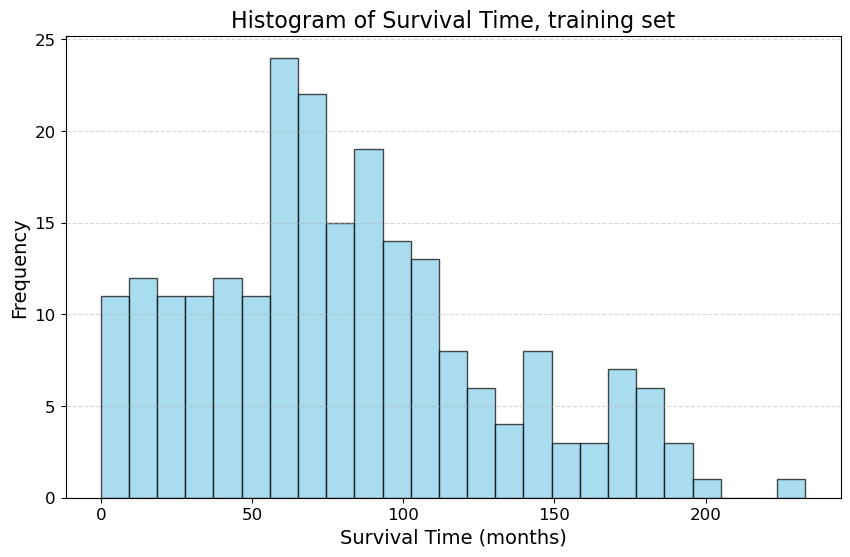

In [4]:
def histogram_outcome(outcome_vector, descriptor):
    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.hist(outcome_vector, bins=25, color='skyblue', edgecolor='black', alpha=0.7)
    
    # Add titles and labels
    plt.title(f'Histogram of {descriptor}', fontsize=16)
    plt.xlabel('Survival Time (months)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    
    # Customize ticks and grid
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Show plot
    plt.show()

histogram_outcome(y_train, "Survival Time, training set")

### Plot correlation matrix


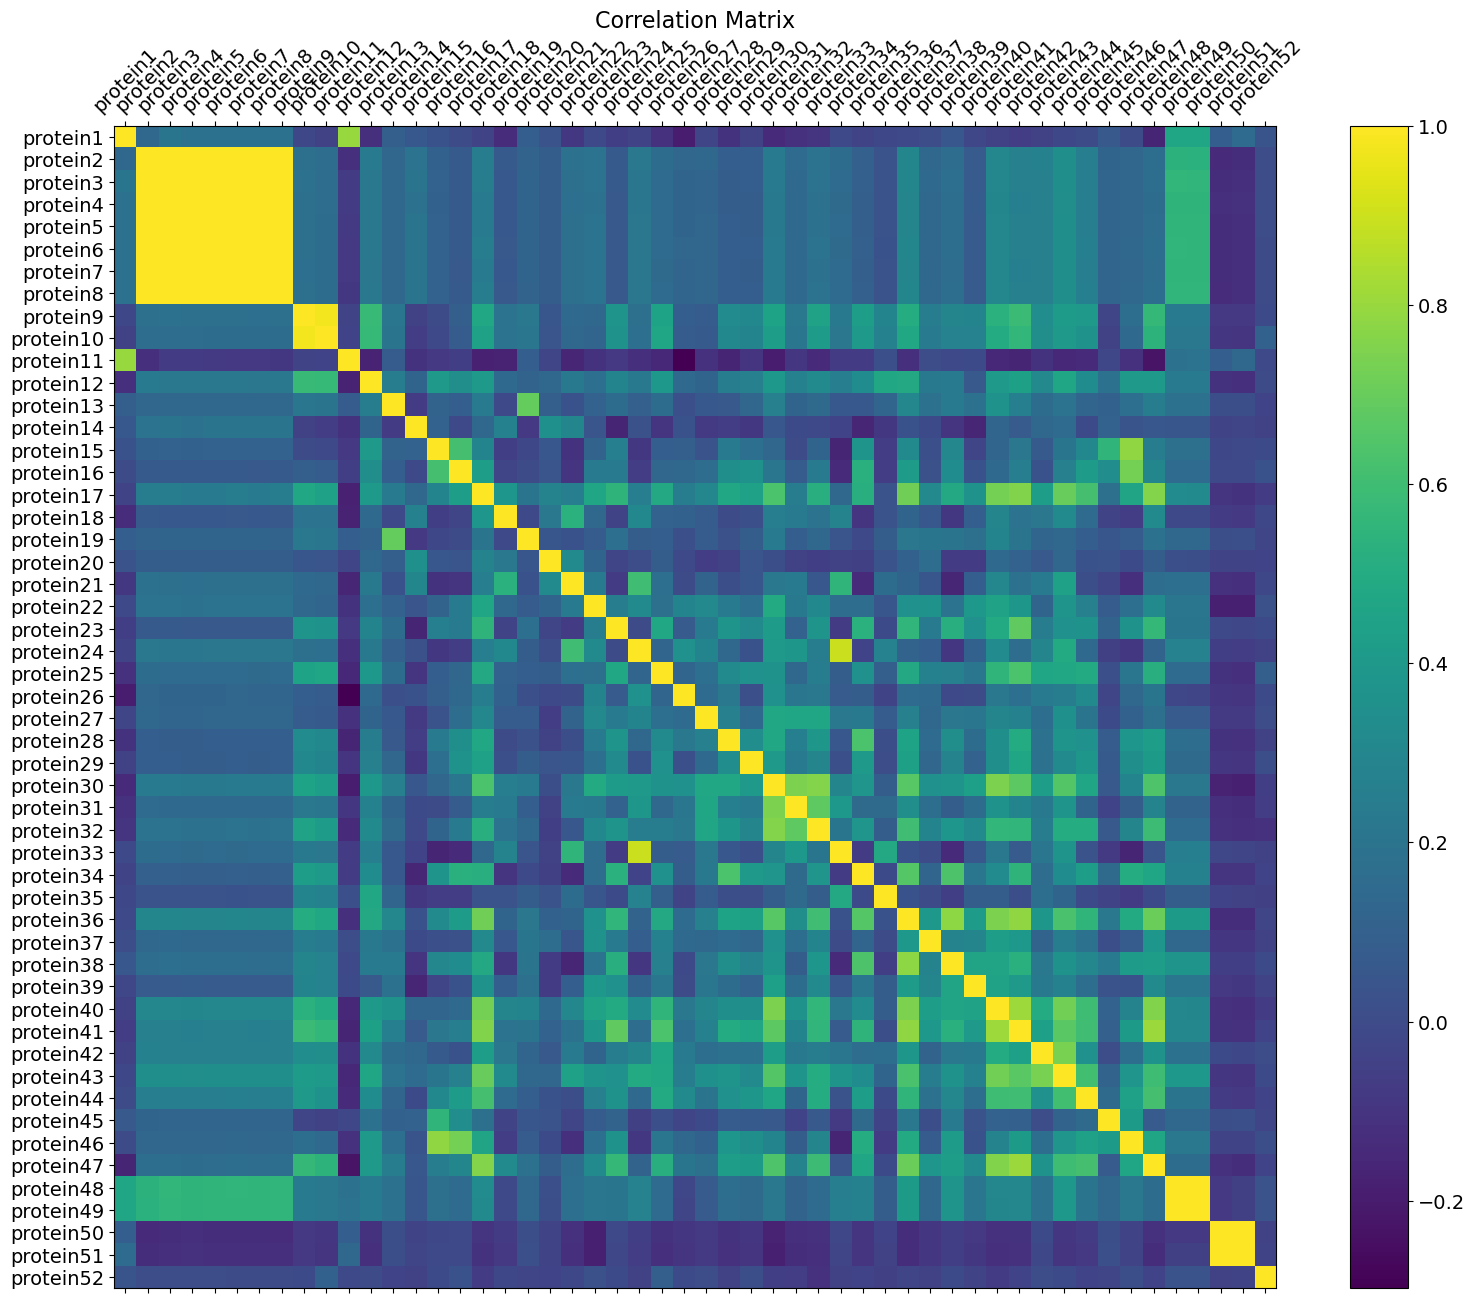

In [5]:
f = plt.figure(figsize=(19, 15))
plt.matshow(X_train.corr(), fignum=f.number)
plt.xticks(range(X_train.select_dtypes(['number']).shape[1]), X_train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(X_train.select_dtypes(['number']).shape[1]), X_train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### Define the model

In [6]:
# Define the neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=n_protein, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model

model = create_model()

### Hyperparameter Tuning / Grid Search

In [7]:
# Wrap Keras model so it can be used by scikit-learn
model_wrapper = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = {
    'epochs': [50, 100, 150],  # Number of epochs to train the model
    'batch_size': [32, 64, 128]  # Batch size used during training
}

grid = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, cv=3,scoring='neg_mean_absolute_error', verbose=1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/var/folders/dj/4nnvmsfx0mx90vrhyz1h1ctw0000gn/T/ipykernel_7290/1559384007.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_wrapper = KerasRegressor(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best: -41.271383 using {'batch_size': 128, 'epochs': 100}


### Train the model 

In [8]:
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2)

Epoch 1/150
6/6 [==============================] - 1s 32ms/step - loss: 6515.3188 - mean_absolute_error: 66.9668 - val_loss: 3944.8354 - val_mean_absolute_error: 46.9607
Epoch 2/150
6/6 [==============================] - 0s 6ms/step - loss: 2458.9692 - mean_absolute_error: 39.4382 - val_loss: 4691.9238 - val_mean_absolute_error: 60.9278
Epoch 3/150
6/6 [==============================] - 0s 6ms/step - loss: 3000.8025 - mean_absolute_error: 47.4481 - val_loss: 4792.4668 - val_mean_absolute_error: 61.7725
Epoch 4/150
6/6 [==============================] - 0s 6ms/step - loss: 2756.7400 - mean_absolute_error: 44.6697 - val_loss: 3955.5437 - val_mean_absolute_error: 52.8508
Epoch 5/150
6/6 [==============================] - 0s 6ms/step - loss: 2429.9485 - mean_absolute_error: 39.3682 - val_loss: 3832.1882 - val_mean_absolute_error: 49.1214
Epoch 6/150
6/6 [==============================] - 0s 6ms/step - loss: 2507.3533 - mean_absolute_error: 38.6943 - val_loss: 3838.8411 - val_mean_absolute_

### Evaluate model

In [9]:
(loss,mae) = model.evaluate(X_train, y_train)
print("Loss:", loss)
print("Mean Absolute Error:", mae)

8/8 [==============================] - 0s 2ms/step - loss: 2300.9512 - mean_absolute_error: 38.8095
Loss: 2300.951171875
Mean Absolute Error: 38.809532165527344


In [10]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

2/2 [==============================] - 0s 2ms/step


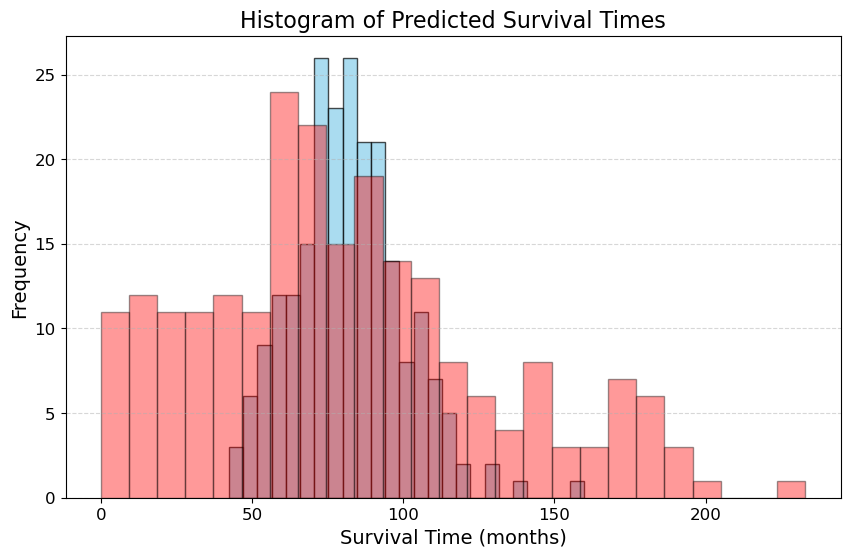

In [11]:
# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(train_predictions, bins=25, color='skyblue', edgecolor='black', alpha=0.7)
plt.hist(y_train, bins=25, color='red', edgecolor='black', alpha=0.4)


# Add titles and labels
plt.title('Histogram of Predicted Survival Times', fontsize=16)
plt.xlabel('Survival Time (months)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customize ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show plot
plt.show()

### Diagnostic Plots

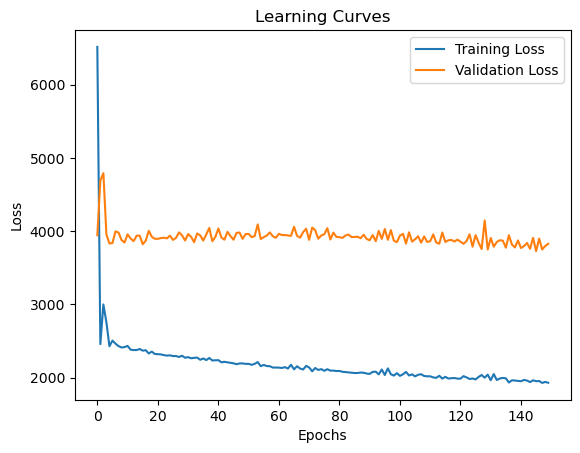

In [12]:
def plot_learning_curves(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming you have trained your model and stored the history object
plot_learning_curves(history)


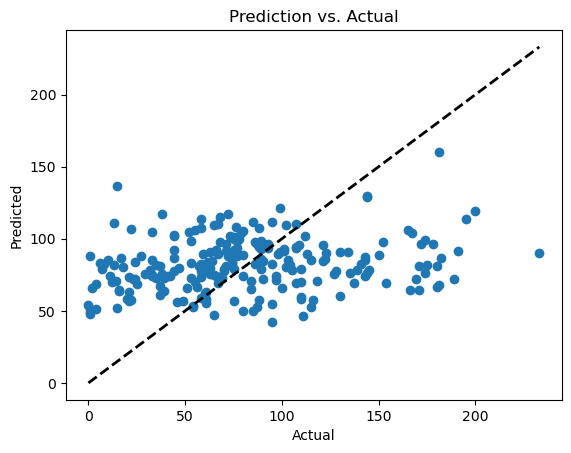

In [13]:
def plot_prediction_vs_actual(y_actual, y_pred):
    plt.scatter(y_actual, y_pred)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Prediction vs. Actual')
    plt.show()

# Assuming y_actual contains the actual target values and y_pred contains the predicted values
plot_prediction_vs_actual(y_train, train_predictions)


In [14]:
# Try to calculate R^2
if np.isnan(np.array(y_train)).any() or np.isnan(train_predictions).any():
    print("Error: Missing values detected.")
else:
    corr_matrix = np.corrcoef(np.array(y_train), train_predictions)
    if np.isnan(corr_matrix[0,1]):
        print("Error: NaN value in correlation coefficient calculation.")
    else:
        corr = corr_matrix[0, 1]
        R_sq = corr ** 2
        print("R-squared:", R_sq)


Error: NaN value in correlation coefficient calculation.


/Users/will/miniconda3/envs/cnn626/lib/python3.8/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/will/miniconda3/envs/cnn626/lib/python3.8/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/will/miniconda3/envs/cnn626/lib/python3.8/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [15]:
# Check for duplicate values
arr = np.array(y_train)

# Get unique values and their first occurrence indices
unique_values, unique_indices = np.unique(arr, return_index=True)

# Check if any indices are duplicated
duplicates_exist = len(unique_indices) != len(arr)

if duplicates_exist:
    duplicate_indices = np.setdiff1d(np.arange(len(arr)), unique_indices)
    print("Indices of duplicates:", duplicate_indices)
else:
    print("No duplicates found in the array.")


Indices of duplicates: [ 25  29  31  32  33  40  42  43  46  47  57  64  67  69  70  72  74  79
  80  84  85  89  94  95  96  97  98 100 105 106 112 113 114 115 118 120
 122 123 125 126 128 131 133 136 138 139 140 142 144 146 150 152 153 154
 156 159 160 161 162 165 166 167 168 169 170 171 172 176 178 179 180 181
 183 185 186 187 188 189 190 191 192 193 197 199 200 201 205 206 207 209
 211 212 213 214 215 220 222 224]


In [16]:
len(duplicate_indices)

98

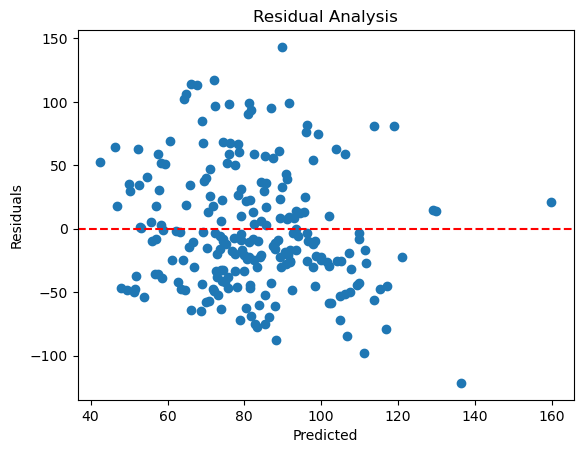

In [17]:
def plot_residuals(y_actual, y_pred):
    residuals = y_actual - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Analysis')
    plt.show()

# Assuming y_actual contains the actual target values and y_pred contains the predicted values
plot_residuals(y_train, train_predictions)

# Random Forest Regression 

In [18]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
regressor.fit(X_train, y_train)

/var/folders/dj/4nnvmsfx0mx90vrhyz1h1ctw0000gn/T/ipykernel_7290/3290205240.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)
/Users/will/miniconda3/envs/cnn626/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [71]:
# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score
 
# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the training data
train_predictions_rf = regressor.predict(X_train)
 
# Evaluating the model
mse = mean_squared_error(y_train, train_predictions_rf)
print(f'Mean Squared Error: {mse}')

errors = abs(train_predictions - y_train)# Print out the mean absolute error (mae)
print(f'Mean Absolute Error: {np.mean(errors)} months')
 
r2 = r2_score(y_train, train_predictions_rf)
print(f'R-squared: {r2}')

Out-of-Bag Score: -0.3879575065333014
Mean Squared Error: 443.9803555555555
Mean Absolute Error: 47.33059950617284  months
R-squared: 0.812285123665042


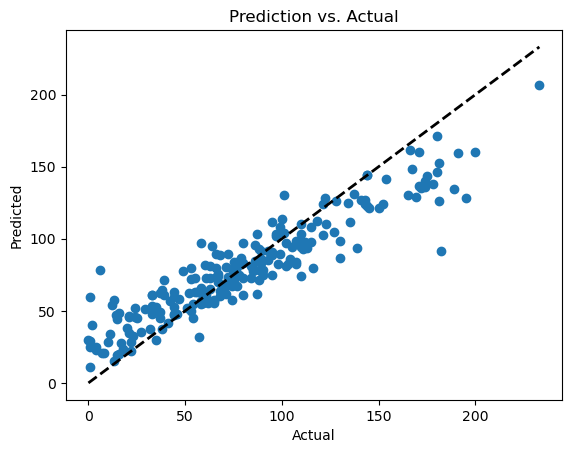

In [90]:
plot_prediction_vs_actual(y_train, train_predictions_rf)

Note the underestimation as values get larger. 

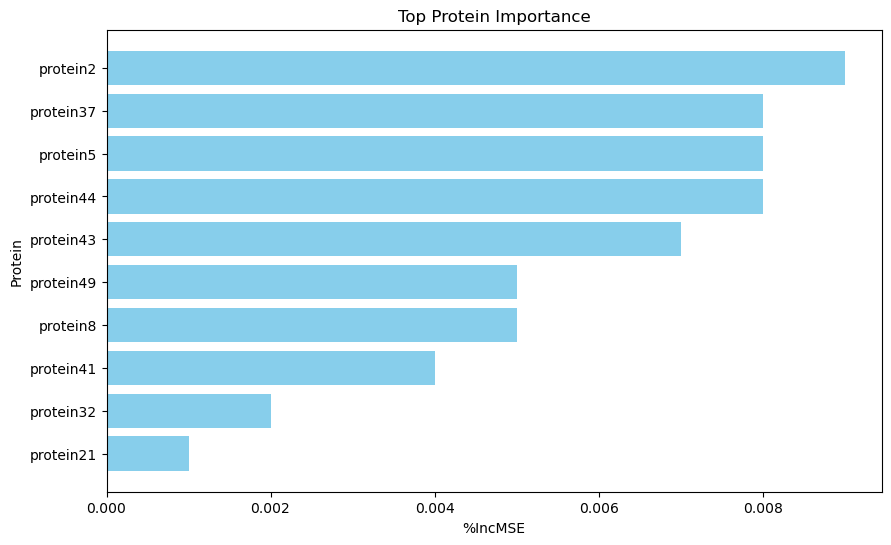

In [56]:
# Get numerical feature importances
importances = list(regressor.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
imp_data = pd.DataFrame(feature_importances, columns=["protein", "%IncMSE"])
imp_data = imp_data.sort_values(by='%IncMSE', ascending=True)
imp_data = imp_data.head(10)
# Plot
plt.figure(figsize=(10, 6))
plt.barh(imp_data['protein'], imp_data['%IncMSE'], color='skyblue')
plt.xlabel('%IncMSE')
plt.ylabel('Protein')
plt.title('Top Protein Importance')
plt.show()

In [73]:
# plot one decision tree
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = regressor.estimators_[5]# Export the image to a dot file
export_graphviz(tree, out_file = 'plots/tree.dot', feature_names = feature_list, rounded = True, precision = 1)# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('plots/tree.dot')
graph.write_png('plots/decision_tree_ex.png')

### Tuning the RF hyperparameters

In [74]:
from sklearn.model_selection import RandomizedSearchCV
hyper_params = {'max_depth': range(3, 20),
                'max_features': range(3,25),
                'min_samples_leaf': range(20,400,50),
                'n_estimators': range(10,101,10)}

model_rcv = RandomizedSearchCV(estimator=regressor,
                               param_distributions = hyper_params,
                               verbose = 1,
                               cv=5,
                               return_train_score=True,
                               n_jobs=-1,
                               n_iter=50)

In [75]:
model_rcv.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/will/miniconda3/envs/cnn626/lib/python3.8/site-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_estimators=10,
                                                   oob_score=True,
                                                   random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': range(3, 20),
                                        'max_features': range(3, 25),
                                        'min_samples_leaf': range(20, 400, 50),
                                        'n_estimators': range(10, 101, 10)},
                   return_train_score=True, verbose=1)

In [77]:
model_rcv.best_score_
model_rcv.best_estimator_

RandomForestRegressor(max_depth=11, max_features=8, min_samples_leaf=20,
                      n_estimators=60, oob_score=True, random_state=0)

In [98]:
# create new RF model based on tuned hyperparameters
regressor2 = RandomForestRegressor(n_estimators=60, max_features=8, random_state=0, oob_score=True)
regressor2.fit(X_train, y_train)

/var/folders/dj/4nnvmsfx0mx90vrhyz1h1ctw0000gn/T/ipykernel_7290/1854218761.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor2.fit(X_train, y_train)


RandomForestRegressor(max_features=8, n_estimators=60, oob_score=True,
                      random_state=0)

In [99]:
# Make predictions
train_predictions_rf2 = regressor2.predict(X_train)

# Evaluating the model
mse = mean_squared_error(y_train, train_predictions_rf2)
print(f'Mean Squared Error: {mse}')

errors = abs(train_predictions_rf2 - y_train)# Print out the mean absolute error (mae)
print(f'Mean Absolute Error: {np.mean(errors)} months')
 
r2 = r2_score(y_train, train_predictions_rf2)
print(f'R-squared: {r2}')

Mean Squared Error: 314.95954691358025
Mean Absolute Error: 46.744176790123454 months
R-squared: 0.866835116329828


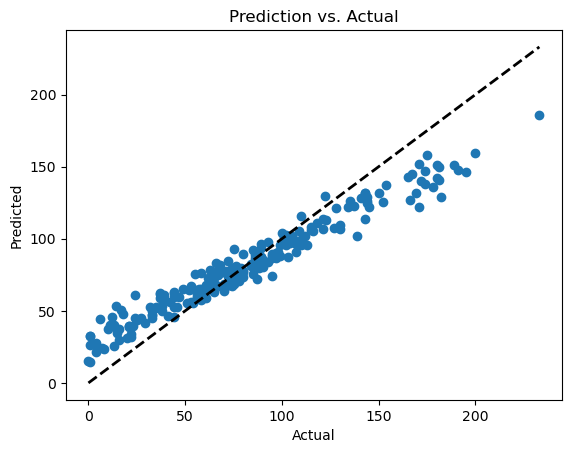

In [103]:
plot_prediction_vs_actual(y_train, train_predictions_rf2)

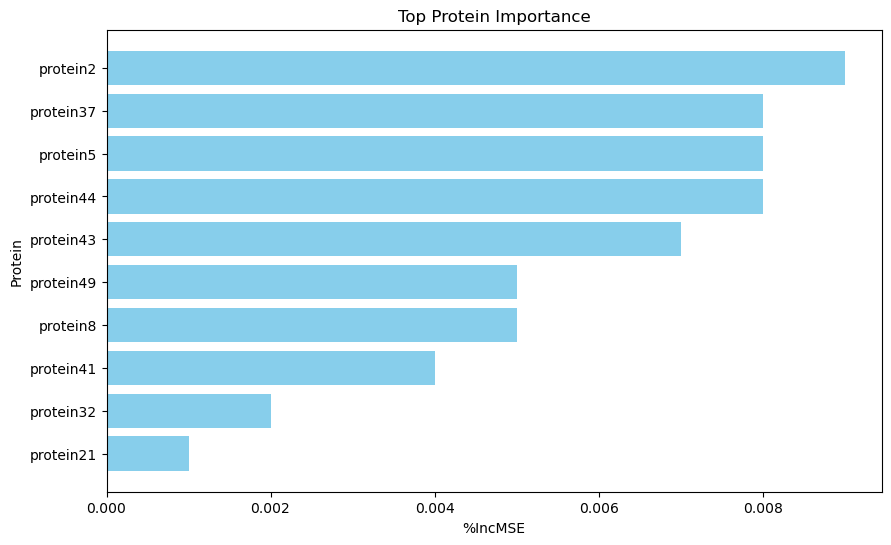

In [101]:
# Get numerical feature importances
importances = list(regressor.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
imp_data = pd.DataFrame(feature_importances, columns=["protein", "%IncMSE"])
imp_data = imp_data.sort_values(by='%IncMSE', ascending=True)
imp_data = imp_data.head(10)
# Plot
plt.figure(figsize=(10, 6))
plt.barh(imp_data['protein'], imp_data['%IncMSE'], color='skyblue')
plt.xlabel('%IncMSE')
plt.ylabel('Protein')
plt.title('Top Protein Importance')
plt.show()

In [132]:
# Save test predictions
test_predictions_rf2 = regressor2.predict(X_test)
id_array = np.array(avgtest_df.id)
out_df = pd.DataFrame({'id': id_array, 'prediction': test_predictions_rf2})
out_df.to_csv("randomforest_predictions.csv")